In [44]:
# Paso 1: Importar librerías necesarias
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import optuna
from lightgbm import early_stopping
from IPython.display import display, HTML
import sys
from contextlib import redirect_stdout
import io

# Paso 2: Conectar a la base de datos SQLite y leer los datos
conn = sqlite3.connect('BDD.db')

query = '''
SELECT s.periodo, s.product_id, s.customer_id, s.plan_precios_cuidados, s.cust_request_qty, s.cust_request_tn, s.tn, p.sku_size, p.brand
FROM tb_sellin s
JOIN tb_productos p ON s.product_id = p.product_id
'''

sellin_data = pd.read_sql_query(query, conn)

# Cerrar la conexión
conn.close()

# Mostrar las primeras filas de los datos leídos
sellin_data.head()


,periodo,product_id,customer_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,sku_size,brand
0,201701,20524,10234,0,2,0.05300,0.05300,500,Importado
1,201701,20524,10032,0,1,0.13628,0.13628,500,Importado
2,201701,20524,10217,0,1,0.03028,0.03028,500,Importado
3,201701,20524,10125,0,1,0.02271,0.02271,500,Importado
4,201701,20524,10012,0,11,1.54452,1.54452,500,Importado


In [45]:
# Paso 3: Preprocesamiento de datos

# Eliminar filas con valores nulos
sellin_data = sellin_data.dropna()

# Verificar si hay valores nulos después de la limpieza
sellin_data.isnull().sum()

periodo                  0
product_id               0
customer_id              0
plan_precios_cuidados    0
cust_request_qty         0
cust_request_tn          0
tn                       0
sku_size                 0
brand                    0
dtype: int64

In [46]:
# Convertir la columna 'brand' a variables dummy (one-hot encoding)
sellin_data = pd.get_dummies(sellin_data, columns=['brand'], drop_first=True)

# Verificar los primeros registros después del encoding
sellin_data.head()

,periodo,product_id,customer_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,sku_size,brand_AYUDIN,brand_CAPILATIS,...,brand_ROPEX1,brand_ROPEX2,brand_SALSATI,brand_SHAMPOO1,brand_SHAMPOO2,brand_SHAMPOO3,brand_SKIN1,brand_TWININGS,brand_VICHY,brand_VIVERE
0,201701,20524,10234,0,2,0.05300,0.05300,500,False,False,...,False,False,False,False,False,False,False,False,False,False
1,201701,20524,10032,0,1,0.13628,0.13628,500,False,False,...,False,False,False,False,False,False,False,False,False,False
2,201701,20524,10217,0,1,0.03028,0.03028,500,False,False,...,False,False,False,False,False,False,False,False,False,False
3,201701,20524,10125,0,1,0.02271,0.02271,500,False,False,...,False,False,False,False,False,False,False,False,False,False
4,201701,20524,10012,0,11,1.54452,1.54452,500,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
# Feature engineering: crear nuevas variables

# Interacción entre cantidad solicitada y tamaño del SKU
sellin_data['qty_x_size'] = sellin_data['cust_request_qty'] * sellin_data['sku_size']

# Logaritmo de la cantidad solicitada (para reducir sesgo si hay valores altos)
sellin_data['log_qty'] = np.log1p(sellin_data['cust_request_qty'])

# Si 'periodo' es una fecha, extraer mes y año (ajusta el formato si es necesario)
sellin_data['periodo'] = pd.to_datetime(sellin_data['periodo'], format='%Y%m')
sellin_data['mes'] = sellin_data['periodo'].dt.month
sellin_data['año'] = sellin_data['periodo'].dt.year

# Total de compras históricas del cliente hasta el periodo anterior
sellin_data = sellin_data.sort_values(['customer_id', 'periodo'])
sellin_data['cliente_total_hist'] = sellin_data.groupby('customer_id')['tn'].cumsum().shift(1)

# Crear lags mensuales de tn por producto
sellin_data = sellin_data.sort_values(['product_id', 'periodo'])
sellin_data['tn_lag_1'] = sellin_data.groupby('product_id')['tn'].shift(1)
sellin_data['tn_lag_3'] = sellin_data.groupby('product_id')['tn'].shift(3)

# Variables de crecimiento (después de crear los lags)
sellin_data['tn_growth_1'] = (sellin_data['tn'] - sellin_data['tn_lag_1']) / sellin_data['tn_lag_1']
sellin_data['tn_growth_3'] = (sellin_data['tn'] - sellin_data['tn_lag_3']) / sellin_data['tn_lag_3']

In [48]:
# Paso 4: Seleccionar las características y la variable objetivo
X = sellin_data[['product_id', 'customer_id', 'plan_precios_cuidados', 'cust_request_qty', 'sku_size', 'qty_x_size', 'log_qty', 'mes', 'año',
                 'tn_lag_1', 'tn_lag_3', 'cliente_total_hist', 'tn_growth_1', 'tn_growth_3'] + 
                [col for col in sellin_data.columns if col.startswith('brand_')]]
y = sellin_data['tn']

In [49]:
# Paso 5: Dividir los datos en conjunto de entrenamiento y prueba (por fecha, no aleatorio)

# Ordenar por periodo para asegurar la secuencia temporal
sellin_data = sellin_data.sort_values('periodo')

# Seleccionar características y variable objetivo nuevamente para asegurar el orden
X = sellin_data[['product_id', 'customer_id', 'plan_precios_cuidados', 'cust_request_qty', 'sku_size', 'qty_x_size', 'log_qty', 'mes', 'año'] + [col for col in sellin_data.columns if col.startswith('brand_')]]
y = sellin_data['tn']

# Definir el tamaño del test (20% final)
test_size = 0.2
n_test = int(len(sellin_data) * test_size)

X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# Mostrar el tamaño de los conjuntos de entrenamiento y prueba
X_train.shape, X_test.shape

((2384962, 45), (596240, 45))

In [50]:
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**param)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[early_stopping(20)]
    )
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

# Limitar el output de Optuna y hacerlo scrolleable


buffer = io.StringIO()
with redirect_stdout(buffer):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)

output = buffer.getvalue()
max_lines = 30  # Cambia este valor según lo que quieras mostrar
lines = output.split('\n')
short_output = '\n'.join(lines[:max_lines])

display(HTML(f"<div style='max-height:300px;overflow:auto;white-space:pre;font-family:monospace'>{short_output}</div>"))

print("Mejores hiperparámetros:", study.best_params)

# Entrenar el mejor modelo encontrado
best_model = lgb.LGBMRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R2:", r2)

[I 2025-05-14 02:39:29,019] A new study created in memory with name: no-name-f917891f-ce64-4c09-82f5-cd73a2aa6387
[I 2025-05-14 02:39:35,262] Trial 0 finished with value: 4.312175742476634 and parameters: {'num_leaves': 22, 'learning_rate': 0.09171644793471717, 'n_estimators': 148, 'max_depth': 4}. Best is trial 0 with value: 4.312175742476634.
[I 2025-05-14 02:39:40,901] Trial 1 finished with value: 4.980451911685419 and parameters: {'num_leaves': 36, 'learning_rate': 0.06694493165831764, 'n_estimators': 156, 'max_depth': 3}. Best is trial 0 with value: 4.312175742476634.
[I 2025-05-14 02:39:47,391] Trial 2 finished with value: 4.242754432348351 and parameters: {'num_leaves': 31, 'learning_rate': 0.10246755056911905, 'n_estimators': 157, 'max_depth': 4}. Best is trial 2 with value: 4.242754432348351.
[I 2025-05-14 02:39:52,639] Trial 3 finished with value: 3.9433501485290203 and parameters: {'num_leaves': 35, 'learning_rate': 0.06694835002407447, 'n_estimators': 104, 'max_depth': 6}. 

Mejores hiperparámetros: {'num_leaves': 40, 'learning_rate': 0.14885987401990775, 'n_estimators': 199, 'max_depth': 6}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 2384962, number of used features: 43
[LightGBM] [Info] Start training from score 0.472234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

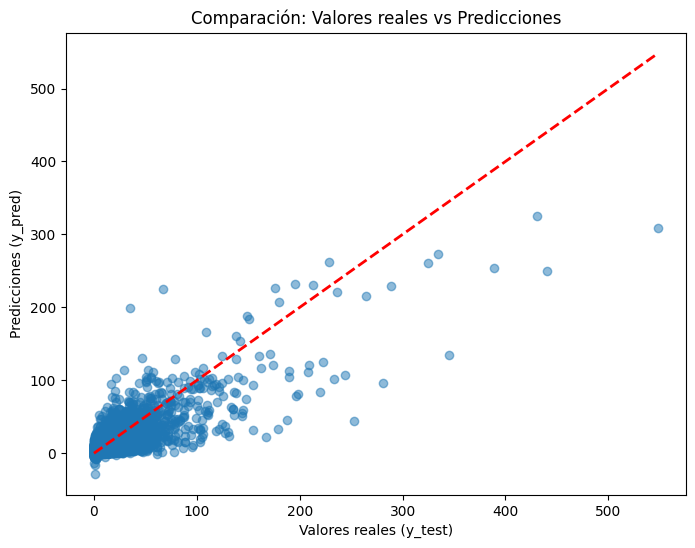

In [51]:
# Visualizar predicción vs real
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.title('Comparación: Valores reales vs Predicciones')
plt.show()

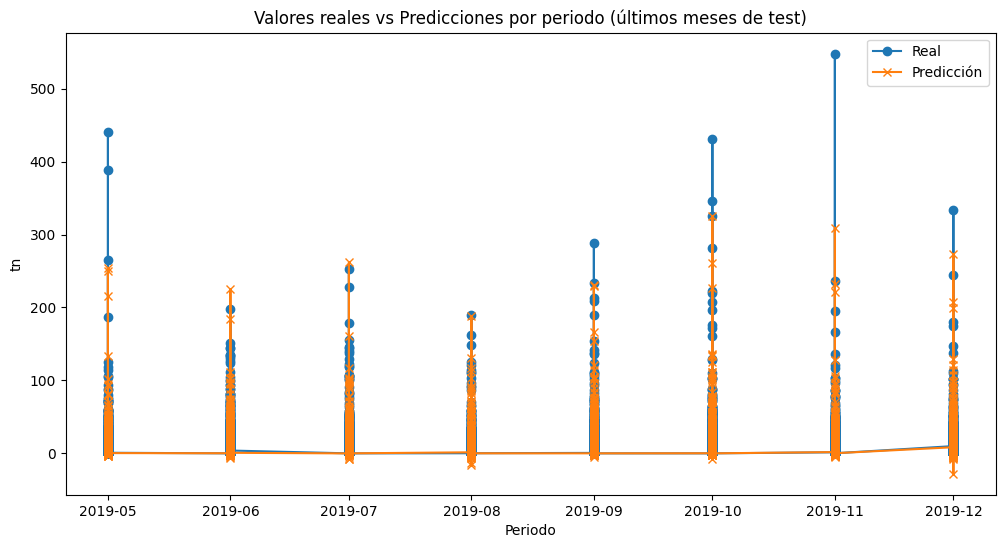

In [52]:
# Visualizar predicción vs real a lo largo del periodo

resultados = X_test.copy()
resultados['periodo'] = sellin_data.loc[X_test.index, 'periodo']  # Asegura que sea datetime
resultados['Real'] = y_test.values
resultados['Predicción'] = y_pred

resultados_ordenados = resultados.sort_values('periodo')

plt.figure(figsize=(12, 6))
plt.plot(resultados_ordenados['periodo'], resultados_ordenados['Real'], label='Real', marker='o')
plt.plot(resultados_ordenados['periodo'], resultados_ordenados['Predicción'], label='Predicción', marker='x')
plt.xlabel('Periodo')
plt.ylabel('tn')
plt.title('Valores reales vs Predicciones por periodo (últimos meses de test)')
plt.legend()
plt.show()